<a href="https://colab.research.google.com/github/lucacamus13/update-Global/blob/main/Update_Global_aperturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install yfinance investpy pandas matplotlib seaborn plotly pytz
!pip install investpy
!pip install fredapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 19.0 MB/s eta 0:00:00
  Created wheel for investpy: filename=investpy-1.0.8-py3-none-any.whl size=4481565 sha256=c3f2a0e6c7e7ba2938eca1340f5894edf05087a56b624f9fedbb1c6f8570fd32
  Stored in directory: /root/.cache/pip/wheels/df/e8/50/8d6a7119bc8829b70c66573d84e09873d611f9244cf5a1d1b2
Successfully built investpy


In [21]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import time
import pytz
import investpy

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from datetime import datetime
import os

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import requests
import re
from bs4 import BeautifulSoup
import warnings

# Aperturas

## Defino función

In [36]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import time
import pytz
import investpy

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
import re
from bs4 import BeautifulSoup
import warnings

def obtener_bolsas_global():
    """Obtener datos de los índices"""

    # Configuración con símbolos mejorados, zonas horarias y horarios
    indices = {
        'EEUU_SP500': {
            'simbolos': ['SPY'],
            'nombre': 'S&P 500',
            'timezone': 'America/New_York', # Zona horaria de Nueva York
            'open_time': '09:30',
            'close_time': '16:00'
        },
        'EEUU_Nasdaq': {
            'simbolos': ['QQQ'],
            'nombre': 'Nasdaq',
            'timezone': 'America/New_York', # Zona horaria de Nueva York
            'open_time': '09:30',
            'close_time': '16:00'
        },
        'UK': {
            'simbolos': ['^FTSE'],
            'nombre': 'FTSE 100',
            'timezone': 'Europe/London', # Zona horaria de Londres
            'open_time': '08:00',
            'close_time': '16:30'
        },
        'ALEMANIA': {
            'simbolos': ['^GDAXI'],
            'nombre': 'DAX P',
            'timezone': 'Europe/Berlin', # Zona horaria de Berlín
            'open_time': '09:00',
            'close_time': '17:30'
        },
        'JAPÓN': {
            'simbolos': ['^N225'],
            'nombre': 'Nikkei 225',
            'timezone': 'Asia/Tokyo', # Zona horaria de Tokio
            'open_time': '09:00',
            'close_time': '15:00'
        },
        'CHINA': {
            'simbolos': ['000001.SS'],
            'nombre': 'Shanghai Composite',
            'timezone': 'Asia/Shanghai', # Zona horaria de Shanghái
            'open_time': '09:30',
            'close_time': '15:00'
        }
    }

    datos = []


    for pais, info in indices.items():
        print(f"\n Obteniendo datos para {pais} ({info['nombre']})...")
        datos_obtenidos = False

        for i, simbolo in enumerate(info['simbolos']):
            try:
                print(f"   {'🎯' if i == 0 else '🔄'} Probando: {simbolo}")

                ticker = yf.Ticker(simbolo)

                # Obtener historial con suficientes días para 5d and 30d lookback
                hist = ticker.history(period="60d")

                if len(hist) >= 2:
                    precio_actual = hist['Close'].iloc[-1]
                    precio_anterior = hist['Close'].iloc[-2]
                    cambio_pct = ((precio_actual - precio_anterior) / precio_anterior) * 100

                    # Calcular variación 5 días hábiles (aproximadamente)
                    precio_5d_ago = None
                    cambio_5d_pct_str = 'N/D'
                    if len(hist) >= 5:
                        precio_5d_ago = hist['Close'].iloc[-5]
                        cambio_5d_pct = ((precio_actual - precio_5d_ago) / precio_5d_ago) * 100
                        cambio_5d_pct_str = f"{cambio_5d_pct:+.2f}%"


                    # Calcular variación 30 días hábiles (aproximadamente)
                    precio_30d_ago = None
                    cambio_30d_pct_str = 'N/D'
                    if len(hist) >= 30:
                        precio_30d_ago = hist['Close'].iloc[-30]
                        cambio_30d_pct = ((precio_actual - precio_30d_ago) / precio_30d_ago) * 100
                        cambio_30d_pct_str = f"{cambio_30d_pct:+.2f}%"


                    # Verificar que los datos son válidos
                    if precio_actual > 0 and not pd.isna(precio_actual):

                        # Obtener información adicional del ticker
                        try:
                            info_ticker = ticker.info
                            nombre_completo = info_ticker.get('longName', info['nombre'])
                        except:
                            nombre_completo = info['nombre']

                        # Determinar estado del mercado considerando zona horaria y horario
                        try:
                            market_timezone = pytz.timezone(info['timezone'])
                            now_local = datetime.now(market_timezone)
                            open_time = datetime.strptime(info['open_time'], '%H:%M').time()
                            close_time = datetime.strptime(info['close_time'], '%H:%M').time()

                            # Check if it's a weekend in the market's timezone
                            if now_local.weekday() >= 5:
                                estado = "CERRADO"
                            else:
                                # Check if current time is within trading hours
                                if now_local.time() >= open_time and now_local.time() <= close_time:
                                    estado = "ABIERTO"
                                else:
                                    estado = "CERRADO"
                        except Exception as tz_e:
                            estado = f"Error TZ: {str(tz_e)[:20]}..." # Handle potential timezone errors
                            print(f"   ⚠️  Error de zona horaria o horario para {pais}: {tz_e}")



                        # Formatear precio de forma general con 2 decimales y separador de miles
                        nivel_str = f"{precio_actual:,.2f}"


                        datos.append({
                            'Índices': pais,
                            'Estado': estado,
                            'Nivel': nivel_str,
                            'Var%': f"{cambio_pct:+.2f}%",
                            'Var 5d%': cambio_5d_pct_str,
                            'Var 30d%': cambio_30d_pct_str,
                            'Símbolo_Usado': simbolo,
                            'Tipo': 'Índice' if i == 0 else 'ETF'
                        })

                        tipo_msg = "✅ ÍNDICE OFICIAL" if i == 0 else "✅ ETF (respaldo)"
                        print(f"   {tipo_msg}: {nivel_str} ({cambio_pct:+.2f}%) | 5d: {datos[-1]['Var 5d%']} | 30d: {datos[-1]['Var 30d%']}")
                        datos_obtenidos = True
                        break
                    else:
                        print(f"   ⚠️  Datos inválidos para {simbolo}")

                else:
                    print(f"   ⚠️  Insuficientes datos históricos para {simbolo}")

            except Exception as e:
                print(f"   ❌ Error con {simbolo}: {str(e)[:50]}...")
                continue

        # Si no se obtuvieron datos con ningún símbolo
        if not datos_obtenidos:
            print(f"   ⚠️  No se pudieron obtener datos para {pais}")
            datos.append({
                'Índices': pais,
                'Estado': 'N/D',
                'Nivel': 'N/D',
                'Var%': 'N/D',
                'Var 5d%': 'N/D',
                'Var 30d%': 'N/D',
                'Símbolo_Usado': 'N/D',
                'Tipo': 'N/D'
            })

    return datos

## Crear tabla

In [37]:
def mostrar_tabla_global():
    """Mostrar la tabla con todos los países"""
    print("Obteniendo datos de Bolsas globales (5 países)...")
    print("=" * 70)

    datos = obtener_bolsas_global()

    # Crear DataFrame para mostrar (sin columnas técnicas)
    df_mostrar = pd.DataFrame([{
        'Índices': d['Índices'],
        'Estado': d['Estado'],
        'Nivel': d['Nivel'],
        'Var%': d['Var%'],
        'Var 5d%': d['Var 5d%'], # Include the new 5d variation column
        'Var 30d%': d['Var 30d%'] # Include the 30d variation column
    } for d in datos])

    # Filter out rows where 'Nivel' is 'N/D'
    df_mostrar = df_mostrar[df_mostrar['Nivel'] != 'N/D'].reset_index(drop=True)


    print("\n" + "="*70)
    print("                        BOLSAS GLOBAL")
    print("="*70)
    print(df_mostrar.to_string(index=False))
    print("="*70)

    # Obtener la hora actual en UTC y convertirla a la zona horaria de Santiago
    utc_now = datetime.now(pytz.utc)
    santiago_timezone = pytz.timezone('America/Santiago')
    santiago_time = utc_now.astimezone(santiago_timezone)

    print(f"🕐 Actualizado: {santiago_time.strftime('%Y-%m-%d %H:%M:%S')}")


    # Mostrar detalles técnicos
    print("\n📋 Detalles técnicos:")
    for dato in datos:
        if dato['Símbolo_Usado'] != 'N/D':
            tipo_emoji = "🎯" if dato['Tipo'] == 'Índice' else "📈"
            print(f"   {tipo_emoji} {dato['Índices']}: {dato['Símbolo_Usado']} ({dato['Tipo']})")

    return df_mostrar

## PNG

In [38]:
def mostrar_dataframe_como_imagen(df, title="Análisis Bolsas Global"):
    """
    Muestra un DataFrame como imagen en el output sin guardar archivo
    """
    # Configurar el tamaño de la figura (ajustado para ser más pequeño)
    fig, ax = plt.subplots(figsize=(12, 2.5)) # Reduced figure size
    ax.axis('tight')
    ax.axis('off')
    ax.grid(False) # Remove grid

    # Crear la tabla
    table = ax.table(cellText=df.values,
                    colLabels=df.columns,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])

    # Personalizar el estilo de la tabla (ajustado para fuente más grande)
    table.auto_set_font_size(False)
    table.set_fontsize(12) # Increased font size
    table.scale(1.2, 2)

    # Colorear el encabezado
    for i in range(len(df.columns)):
        table[(0, i)].set_facecolor('#000080') # Navy blue color
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Colorear las filas alternadas y las variaciones
    for i in range(1, len(df) + 1):
        for j in range(len(df.columns)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
            else:
                table[(i, j)].set_facecolor('white')

            # Colorear las columnas de variación
            if df.columns[j] in ['Var%', 'Var 5d%', 'Var 30d%']:
                cell_text = table[(i, j)].get_text().get_text()
                if cell_text.startswith('+'):
                    table[(i, j)].set_text_props(color='green')
                elif cell_text.startswith('-'):
                    table[(i, j)].set_text_props(color='red')


    # Agregar título con fecha y hora local
    # Obtener la hora actual en UTC y convertirla a la zona horaria de Santiago
    utc_now = datetime.now(pytz.utc)
    santiago_timezone = pytz.timezone('America/Santiago')
    santiago_time = utc_now.astimezone(santiago_timezone)
    current_time_str = santiago_time.strftime("%Y-%m-%d %H:%M:%S")

    plt.title(f'{title}\n(Actualizado: {current_time_str})', fontsize=14, fontweight='bold', pad=20)

    # Agregar marca de agua
    plt.figtext(0.95, 0.05, '@camusluca',
                fontsize=10, color='gray', ha='center', va='bottom', alpha=0.5)

    # Agregar timestamp (redundante con el título, pero se mantiene por si acaso)
    # plt.figtext(0.02, 0.02, f'Generado: {timestamp}', fontsize=8, alpha=0.7)

    # Mostrar la imagen en el output
    plt.tight_layout()
    plt.show()

    print(f"✅ DataFrame mostrado como imagen en el output")
    return fig

def mostrar_multiples_vistas(df):
    """
    Muestra múltiples vistas del DataFrame en el output
    """
    # Vista completa
    mostrar_dataframe_como_imagen(df, "Análisis Completo - Bolsas Latam (6 países)")

    # # Vista resumida (if needed - currently commented out)
    # if len(df.columns) > 6:
    #     # Select the first 6 most relevant columns
    #     df_resumido = df.iloc[:, :6]
    #     mostrar_dataframe_como_imagen(df_resumido, "Vista Resumida - Bolsas Latam")

    # # Vista con estadísticas básicas (if needed - currently commented out)
    # if df.select_dtypes(include=[np.number]).shape[1] > 0:
    #     df_stats = df.describe()
    #     mostrar_dataframe_como_imagen(df_stats, "Estadísticas Descriptivas - Bolsas Latam")

🚀 Iniciando análisis de Bolsas Globales
Obteniendo datos de Bolsas globales (5 países)...

 Obteniendo datos para EEUU_SP500 (S&P 500)...
   🎯 Probando: SPY
   ✅ ÍNDICE OFICIAL: 627.58 (-0.07%) | 5d: +0.44% | 30d: +6.14%

 Obteniendo datos para EEUU_Nasdaq (Nasdaq)...
   🎯 Probando: QQQ
   ✅ ÍNDICE OFICIAL: 561.26 (-0.10%) | 5d: +0.91% | 30d: +7.07%

 Obteniendo datos para UK (FTSE 100)...
   🎯 Probando: ^FTSE
   ✅ ÍNDICE OFICIAL: 8,992.10 (+0.22%) | 5d: -0.07% | 30d: +1.81%

 Obteniendo datos para ALEMANIA (DAX P)...
   🎯 Probando: ^GDAXI
   ✅ ÍNDICE OFICIAL: 24,289.51 (-0.33%) | 5d: +0.53% | 30d: +0.48%

 Obteniendo datos para JAPÓN (Nikkei 225)...
   🎯 Probando: ^N225
   ✅ ÍNDICE OFICIAL: 39,819.11 (-0.21%) | 5d: +0.91% | 30d: +4.54%

 Obteniendo datos para CHINA (Shanghai Composite)...
   🎯 Probando: 000001.SS
   ✅ ÍNDICE OFICIAL: 3,549.89 (+0.44%) | 5d: +1.28% | 30d: +4.88%

                        BOLSAS GLOBAL
    Índices  Estado     Nivel   Var% Var 5d% Var 30d%
 EEUU_SP500 CER

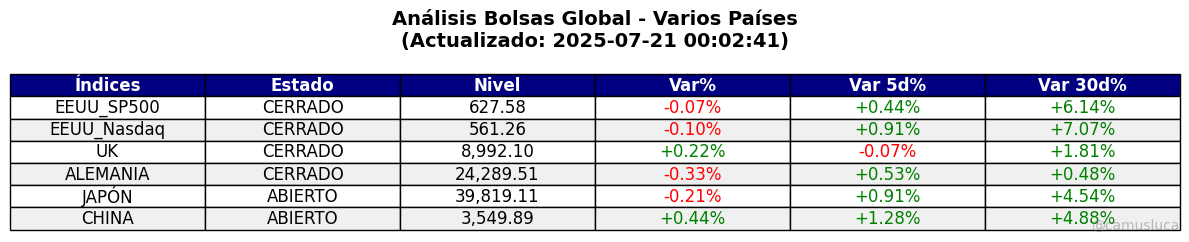

✅ DataFrame mostrado como imagen en el output
✅ Todas las imágenes han sido mostradas en el output

🎯 Análisis completado exitosamente!


In [39]:
# Ejecutar
if __name__ == "__main__":
    print("🚀 Iniciando análisis de Bolsas Globales")
    print("=" * 70)

    # Ejecutar función principal y capturar el DataFrame
    # Reemplazamos la llamada a mostrar_tabla_con_ipsa() por mostrar_tabla_global()
    df_resultado = mostrar_tabla_global()

    print("\n" + "=" * 70)
    print("📊 Mostrando DataFrame como imagen en el output...")

    # Verificar si se obtuvo un DataFrame
    if df_resultado is not None and isinstance(df_resultado, pd.DataFrame):
        # Mostrar imagen principal
        mostrar_dataframe_como_imagen(df_resultado, "Análisis Bolsas Global - Varios Países")

        # Mostrar múltiples vistas (if needed - currently commented out)
        # mostrar_multiples_vistas(df_resultado)

        print("✅ Todas las imágenes han sido mostradas en el output")
    else:
        print("❌ No se pudo obtener el DataFrame para mostrar las imágenes")
        print("   Verifica que la función mostrar_tabla_global() retorne un DataFrame")

    print("\n" + "=" * 70)
    print("🎯 Análisis completado exitosamente!")